# Gateway to Research Discipline Labelling

We use an older version of GtR with better topic coverage to

* Analyse the community structure of the topic co-occurrence network to identify disciplines
* Train a discipline classifier that we can use with the latest GtR data.

## Preamble

In [2]:
#import matplotlib
#matplotlib.use('cairo')

In [3]:
import ast
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
% matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

plt.rc('font', family = 'serif',serif='Times New Roman') 

In [4]:
# %load lda_pipeline.py
from gensim import corpora, models
from string import punctuation
from string import digits
import re
import pandas as pd
import numpy as np

#Characters to drop
drop_characters = re.sub('-','',punctuation)+digits

#Stopwords
from nltk.corpus import stopwords

stop = stopwords.words('English')

#Stem functions
from nltk.stem import *
stemmer = PorterStemmer()


# Utility functions

def flatten_list(my_list):
    '''
    Flattens a list
    '''
    
    return([x for el in my_list for x in el])

def flatten(my_list):
    '''
    Flattens a list
    '''
    
    return([x for el in my_list for x in el])


def clean_tokenise(string,drop_characters=drop_characters,stopwords=stop):
    '''
    Takes a string and cleans (makes lowercase and removes stopwords)
    
    '''
    

    #Lowercase
    str_low = string.lower()
    
    
    #Remove symbols and numbers
    str_letters = re.sub('[{drop}]'.format(drop=drop_characters),'',str_low)
    
    
    #Remove stopwords
    clean = [x for x in str_letters.split(' ') if (x not in stop) & (x!='')]
    
    return(clean)


class CleanTokenize():
    '''
    This class takes a list of strings and returns a tokenised, clean list of token lists ready
    to be processed with the LdaPipeline
    
    It has a clean method to remove symbols and stopwords
    
    It has a bigram method to detect collocated words
    
    It has a stem method to stem words
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes a corpus (list where each element is a string)
        '''
        
        #Store
        self.corpus = corpus
        
    def clean(self,drop=drop_characters,stopwords=stop):
        '''
        Removes strings and stopwords, 
        
        '''
        
        cleaned = [clean_tokenise(doc,drop_characters=drop,stopwords=stop) for doc in self.corpus]
        
        self.tokenised = cleaned
        return(self)
    
    def stem(self):
        '''
        Optional: stems words
        
        '''
        #Stems each word in each tokenised sentence
        stemmed = [[stemmer.stem(word) for word in sentence] for sentence in self.tokenised]
    
        self.tokenised = stemmed
        return(self)
        
    
    def bigram(self,threshold=10):
        '''
        Optional Create bigrams.
        
        '''
        
        #Colocation detector trained on the data
        phrases = models.Phrases(self.tokenised,threshold=threshold)
        
        bigram = models.phrases.Phraser(phrases)
        
        self.tokenised = bigram[self.tokenised]
        
        return(self)
        
        
        
        

class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
    
    def clean(self):
        '''
        Remove symbols and numbers
        
        '''
        
        
        
    
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

## Import Data

If you have cloned the repo, get the data [here](https://drive.google.com/open?id=1N62n0Pi7W63uWFaiWHNJMJdsRWd58UIZ)

In [5]:
raw_gtr_df = pd.read_csv(
    '../data/external/gtr/gtr_projects.csv',
    converters={
        'research_topics': ast.literal_eval,
        'researc_subjects': ast.literal_eval,
    }
)

gtr_df = raw_gtr_df[(raw_gtr_df['start_year'] >= 2006) & (raw_gtr_df['start_year'] < 2017)]
#gtr_df = gtr_df[(gtr_df['funder_name'] != 'BBSRC') & (gtr_df['funder_name'] != 'MRC')]

## Identify topic communities in the period

#### Create all years co-occurrence graph

In [6]:
import itertools
import networkx as nx
import community

In [7]:
# We will create an edgelist from the groups in each project

#This creates combinations 
combs = [sorted(tuple) for tuple in flatten([list(itertools.combinations(vals,2)) for vals in gtr_df['research_topics']])]

#Count combinations (this is the weight)
combs_df = pd.Series(['__'.join(x) for x in combs]).value_counts().reset_index(drop=False)

combs_df.columns = ['vars','weight']

#This is an edgelist
combs_df['source'],combs_df['target'] = [[v.split('__')[num] for v in combs_df['vars']] for num in [0,1]]

combs_df.drop(['vars'],axis=1,inplace=True)

In [8]:
#Create a network
network = nx.from_pandas_edgelist(combs_df,edge_attr='weight')

#Extract the best partition
part = community.best_partition(network,resolution=0.9)

NB This is only a preliminary analysis that we still need to tune

In [9]:
#What do these look like?
pd.Series(part).reset_index(drop=False).groupby(0)['index'].apply(lambda x: print(' '.join(list(x))+'\n'))

Materials Characterisation Materials Synthesis & Growth Materials Processing Condensed Matter Physics Instrumentation Eng. & Dev. Solar Technology Materials testing & eng. Electronic Devices & Subsys. Magnetism/Magnetic Phenomena Reactor Engineering Building Ops & Management Energy Efficiency Surfaces & Interfaces Eng. Dynamics & Tribology Manufacturing Machine & Plant Urban & Land Management Biomaterials Tissue engineering Cold Atomic Species Quantum Optics & Information Complex fluids & soft solids High Performance Computing Optoelect. Devices & Circuits Heat & Mass Transfer Med.Instrument.Device& Equip. Medical Imaging Fuel Cell Technologies Optical Devices & Subsystems Civil Engineering Materials Structural Engineering Bioprocess Engineering Design of Process systems Biomechanics & Rehabilitation Drug Formulation & Delivery Construction Ops & Management Lasers & Optics Electrochemical Science & Eng. Bioenergy Control Engineering Acoustics Manufact. Enterprise Ops& Mgmt Ground Engin

0
0    None
1    None
2    None
3    None
4    None
5    None
6    None
Name: index, dtype: object

The communities look intuitive. We will create a lookup and convert each topic into its discipline.

We will assign projects to their top discipline distinguishing between 'pure' discipline projects and mixed ones.

In [11]:
category_name_lookup = {6:'biological_sciences',
                        3:'physics',
                        0:'engineering_technology',
                        1:'environmental_sciences',
                        2:'social_sciences',
                        4:'arts_humanities',
                       5:'mathematics_computing'}


topic_discipline_lookup = {top:category_name_lookup[disc] for top,disc in part.items()}

Now we look-up the disciplines

In [12]:
gtr_df['discipline'] = gtr_df['research_topics'].apply(lambda x: [topic_discipline_lookup[val] for val in x])

gtr_df['discipline_sets'] = [set(x) for x in gtr_df['discipline']]

gtr_df['single_disc'] = [True if len(x)==1 else np.nan if len(x)==0 else False for x in gtr_df['discipline_sets']]

gtr_df['single_disc'].mean()

0.8111367805938711

82% of projects are pure discipline

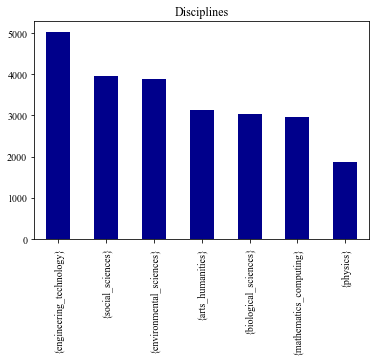

In [13]:
gtr_df.loc[gtr_df.single_disc==True,'discipline_sets'].value_counts().plot.bar(color='darkblue',title='Disciplines')

Note the absence of medical sciences

In [14]:
#Now we very crudely assume that any project funded by the MRC is in 'Health'

gtr_df['discipline_sets'] = [set(['medical_sciences']) if f =='MRC' else x for f,x in zip(gtr_df['funder_name'],
                                                                                       gtr_df['discipline_sets'])]

In [15]:
#And now we create the training set

#Also dropping the cases with no abstracts
gtr_pure = gtr_df.loc[[len(x)==1 for x in gtr_df['discipline_sets']]].dropna(axis=0,subset=['abstract_texts'])

gtr_pure.funder_name.value_counts()

EPSRC    9059
MRC      4528
ESRC     3909
NERC     3810
AHRC     3212
BBSRC    1994
STFC     1882
Name: funder_name, dtype: int64

### Classification

In [16]:
#ML imports
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

import warnings

warnings.simplefilter('ignore',UserWarning)

In [17]:
# Utility functions

def flatten_list(my_list):
    '''
    Flattens a list
    '''
    
    return([x for el in my_list for x in el])


def dummies_from_list(list_of_categories):
    '''
    This function takes a list of categories and returns a df where every column is a dummie for each unique variable
    in the category. Admittedly, the function could be nicer.
    
    '''

    #We concatenate a bunch of series whose indices are the names of the variables.
    #We could have done something similar by creating DFs with one row
    
    cats = [x for x in set(flatten_list(list_of_categories))]

    df = pd.DataFrame()

    for category in cats:
    
        var = [category in x for x in list_of_categories]

        df[category] = var

    
    
    
    #dummy_df = pd.concat([pd.Series({v:1 for v in obs}) for obs in list_of_categories],axis=1).T.fillna(0)
    return(df)

In [18]:
# %load text_classifier.py
# CLasses

#One class for text classification based on text inputs

class TextClassification():
    '''
    This class takes a corpus (could be a list of strings or a tokenised corpus) and a target (could be multiclass or single class).
    
    When it is initialised it vectorises the list of tokens using sklearn's count vectoriser.
    
    It has a grid search method that takes a list of models and parameters and trains the model.
    
    It returns the output of grid search for diagnosis
    
    '''
    
    def __init__(self,corpus,target):
        '''
        
        Initialise. The class will recognise if we are feeding it a list of strings or a list of
        tokenised documents and vectorise accordingly. 
        
        It will also recognise is this a multiclass or one class problem based on the dimensions of the target array
        
        Later on, it will use control flow to modify model parameters depending on the type of data we have
        
        '''
        
        #Is this a multiclass classification problem or a single class classification problem?
        if target.shape[1]>1:
            self.mode = 'multiclass'
            
        else:
            self.mode = 'single_class'
    
    
        #Store the target
        self.Y = target
    
        #Did we feed the model a bunch of strings or a list of tokenised docs? If the latter, we clean and tokenise.
        
        if type(corpus[0])==str:
            #corpus = CleanTokenize(corpus).clean().bigram().tokenised
            corpus = CleanTokenize(corpus).clean().tokenised
            
        #Turn every list of tokens into a string for count vectorising
        corpus_string =  [' '.join(words) for words in corpus]
        
        
        #And then we count vectorise in a hacky way.
        count_vect = CountVectorizer(stop_words='english',min_df=5).fit(corpus_string)
        
        #Store the features
        self.X = count_vect.transform(corpus_string)
        
        #Store the count vectoriser (we will use it later on for prediction on new data)
        self.count_vect = count_vect
        
    def grid_search(self,models):
        '''
        The grid search method takes a list with models and their parameters and it does grid search crossvalidation.
        
        '''
        
        #Load inputs and targets into the model
        Y = self.Y
        X = self.X
        
        if self.mode=='multiclass':
            '''
            If the model is multiclass then we need to add some prefixes to the model paramas
            
            '''
        
            for mod in models:
                #Make ovr
                mod[0] = OneVsRestClassifier(mod[0])
                
                #Add the estimator prefix
                mod[1] = {'estimator__'+k:v for k,v in mod[1].items()}
                
        
        #Container with results
        results = []

        #For each model, run the analysis.
        for num,mod in enumerate(models):
            print(num)

            #Run the classifier
            clf = GridSearchCV(mod[0],mod[1])

            #Fit
            clf.fit(X,Y)

            #Append results
            results.append(clf)
        
        self.results = results
        return(self)

    
#Class to visualise the outputs of multilabel models.

#I call it OrangeBrick after YellowBrick, the package for ML output visualisation 
#(which currently doesn't support multilabel classification)


class OrangeBrick():
    '''
    This class takes a df with the true classes for a multilabel classification exercise and produces some charts visualising findings.
    
    The methods include:
    
        .confusion_stack: creates a stacked barchart with the confusion matrices stacked by category, sorting classes by performance
        .prec_rec: creates a barchart showing each class precision and recall;
        #Tobe done: Consider mixes between classes?
    
    '''
    
    def __init__(self,true_labels,predicted_labels,var_names):
        '''
        Initialise with a true labels, predicted labels and the variable names
        '''
         
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.var_names = var_names
    
    def make_metrics(self):
        '''
        Estimates performance metrics (for now just confusion charts by class and precision/recall scores for the 0.5 
        decision rule.
        
        '''
        #NB in a confusion matrix in SKlearn the X axis indicates the predicted class and the Y axis indicates the ground truth.
        #This means that:
            #cf[0,0]-> TN
            #cf[1,1]-> TP
            #cf[0,1]-> FN (prediction is false, groundtruth is true)
            #cf[1,0]-> FP (prediction is true, ground truth is false)



        #Predictions and true labels
        true_labels = self.true_labels
        pred_labels = self.predicted_labels

        #Variable names
        var_names = self.var_names

        #Store confusion matrices
        score_store = []


        for num in np.arange(len(var_names)):

            #This is the confusion matrix
            cf = confusion_matrix(pred_labels[:,num],true_labels[:,num])

            #This is a melted confusion matrix
            melt_cf = pd.melt(pd.DataFrame(cf).reset_index(drop=False),id_vars='index')['value']
            melt_cf.index = ['true_negative','false_positive','false_negative','true_positive']
            melt_cf.name = var_names[num]
            
            #Order variables to separate failed vs correct predictions
            melt_cf = melt_cf.loc[['true_positive','true_negative','false_positive','false_negative']]

            #We are also interested in precision and recall
            prec = cf[1,1]/(cf[1,1]+cf[1,0])
            rec = cf[1,1]/(cf[1,1]+cf[0,1])

            prec_rec = pd.Series([prec,rec],index=['precision','recall'])
            prec_rec.name = var_names[num]
            score_store.append([melt_cf,prec_rec])
    
        self.score_store = score_store
        
        return(self)
    
    def confusion_chart(self,ax):
        '''
        Plot the confusion charts
        
        
        '''
        
        #Visualise confusion matrix outputs
        cf_df = pd.concat([x[0] for x in self.score_store],1)

        #This ranks categories by the error rates
        failure_rate = cf_df.apply(lambda x: x/x.sum(),axis=0).loc[['false' in x for x in cf_df.index]].sum().sort_values(
            ascending=False).index

        
        #Plot and add labels
        cf_df.T.loc[failure_rate,:].plot.bar(stacked=True,ax=ax,width=0.8,cmap='Accent')

        ax.legend(bbox_to_anchor=(1.01,1))
        #ax.set_title('Stacked confusion matrix for disease areas',size=16)
    
    
    def prec_rec_chart(self,ax):
        '''
        
        Plot a precision-recall chart
        
        '''
    

        #Again, we sort them here to assess model performance in different disease areas
        prec_rec = pd.concat([x[1] for x in self.score_store],1).T.sort_values('precision')
        prec_rec.plot.bar(ax=ax)

        #Add legend and title
        ax.legend(bbox_to_anchor=(1.01,1))
        #ax.set_title('Precision and Recall by disease area',size=16)

In [19]:
#Here is the corpus
corpus = list(gtr_pure['abstract_texts'])

#We use a utility function to create a df for a one vs rest classification
target = dummies_from_list(gtr_pure['discipline_sets'])


In [20]:
#Run grid search with these model parameters
models = [
    [RandomForestClassifier(),
     {'class_weight':['balanced',None],'min_samples_leaf':[1,5]}],
    
    [LogisticRegression(),
     {'class_weight':['balanced',None],'penalty':['l1','l2'],
      'C':[0.1,1,100]}]]

In [21]:
# Predict groups

#Initialise the TextClassification class
gtr_t = TextClassification(corpus,target)

In [22]:
gtr_t.grid_search(models)

0


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn

1


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be change

In [23]:
#Check scores and best estimators
for res in gtr_t.results:
    print(res.best_score_)
    print(res.best_estimator_)
    
    #This is the best estimator
best_est = gtr_t.results[1].best_estimator_

0.5348313023878284
OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          n_jobs=None)
0.6985982954145242
OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)


In [24]:
gtr_diag = OrangeBrick(true_labels=np.array(target),
                      predicted_labels=best_est.predict(gtr_t.X),
                      var_names=target.columns).make_metrics()

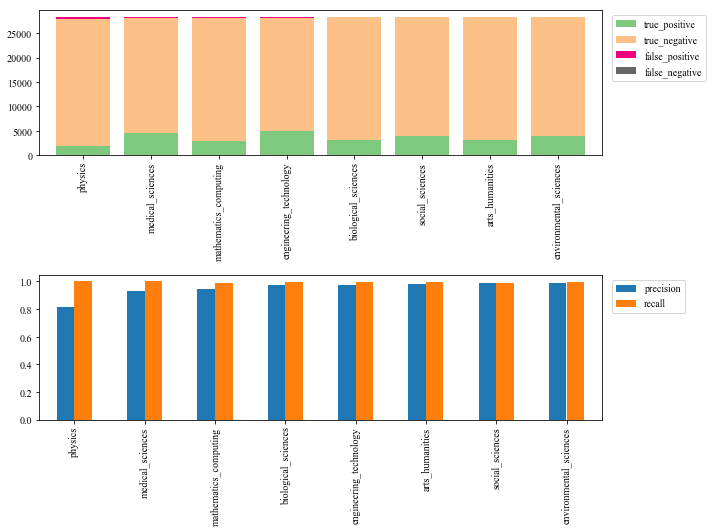

In [25]:
fig,ax = plt.subplots(nrows=2,figsize=(10,7.5))

gtr_diag.confusion_chart(ax=ax[0])
gtr_diag.prec_rec_chart(ax=ax[1])

#fig.suptitle('Model evaluation for GTR disciplines',y=1.01,size=16)

plt.tight_layout()

plt.savefig('../../Mapping_Missions/figures/fig_3_model_validation',
            bbox_to_inches='tight')

Not bad

## Load models for prediction

In [28]:
gtr_unlabelled = pd.read_csv('../data/processed/22_1_2019_gtr_for_prediction.csv')

During EDA we have noticed several garbagey abstract names. Let's weed them out

In [29]:
beginning_abs = pd.Series([x[:100] for x in gtr_unlabelled['abstractText']]).value_counts()

beginning_abs[:10]

Abstracts are not currently available in GtR for all funded research. This is normally because the a    7106
Doctoral Training Partnerships: a range of postgraduate training is funded by the Research Councils.    5432
Awaiting Public Project Summary                                                                         1098
The public description for this project has been requested but has not yet been received.                360
No abstract available.                                                                                   179
TBC                                                                                                       64
none                                                                                                      59
This student is enrolled on the Oxford Interdisciplinary Bioscience Doctoral Training Partnership. T      55
MIBTP students undertake a year of training before deciding on a final PhD project. The training per      49
Refer to ATLAS-UK u

In [30]:
beginning_abs.describe()

count    62429.000000
mean         1.391613
std         36.104589
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       7106.000000
dtype: float64

For now we will drop any project with abstract appearing > 25 times

In [31]:
uninformative_abstracts = list(beginning_abs.index[beginning_abs>25])

In [32]:
gtr_unlabelled_cleaned = gtr_unlabelled.loc[[x[:100] not in uninformative_abstracts for x in gtr_unlabelled['abstractText']]]

In [33]:
gtr_unlab_features = gtr_t.count_vect.transform(gtr_unlabelled_cleaned['abstractText'])

In [34]:
#Predicted labels
gtr_unlab_probs = pd.DataFrame(best_est.predict_proba(gtr_unlab_features),columns=target.columns)

#Get discipline names to subset things easily later
discs = target.columns

In [35]:
gtr_predicted = pd.concat([gtr_unlabelled_cleaned.reset_index(drop=False),gtr_unlab_probs],axis=1)

gtr_predicted.head()

,index,id_x,end_x,start_x,category,amount,currencyCode,year,rel,table_name,...,research_activities,has_activities,mathematics_computing,physics,social_sciences,engineering_technology,environmental_sciences,medical_sciences,biological_sciences,arts_humanities
0,00006CB7-61E0-4946-B7DB-DAE09ED63DE4,3CF0A86B-4545-4749-B874-5CB8C6B4DFC8,2014-04-30 01:00:00,2013-10-01 01:00:00,INCOME_ACTUAL,5000.0,GBP,2013.0,FUND,gtr_funds,...,[],False,4.353165e-01,6.460216e-01,2.032806e-01,0.395257,0.212150,5.215226e-01,0.060881,1.409546e-01
1,0003C360-5DB8-4930-8266-6218C633A504,0B022BF4-F896-4B6F-AAC1-6C914450B17F,2020-09-30 01:00:00,2017-10-01 01:00:00,INCOME_ACTUAL,0.0,GBP,2017.0,FUND,gtr_funds,...,[],False,9.903865e-04,2.355843e-03,8.599137e-01,0.027141,0.003403,7.196704e-03,0.005128,3.397699e-01
2,000423DA-5A37-4E62-A698-703985CD4E6E,06BAF35F-97E8-4761-8A79-15AA61D9326F,2015-09-30 01:00:00,2012-10-01 01:00:00,INCOME_ACTUAL,26776.0,GBP,2012.0,FUND,gtr_funds,...,[],False,1.354333e-08,9.990077e-01,6.458135e-10,0.011196,0.000041,1.769562e-08,0.000198,4.713474e-11
3,000424B1-378E-4AB6-BAEC-CD8607AE08A9,10882C29-7FE4-43E8-A30A-94356100EE76,2016-10-06 01:00:00,2013-01-07 00:00:00,INCOME_ACTUAL,419504.0,GBP,2013.0,FUND,gtr_funds,...,[],False,2.188568e-04,4.533677e-09,3.559316e-05,0.000621,0.000004,3.792511e-01,0.997432,3.169161e-06
4,0004C698-0B51-4665-8593-1082BBF58C06,B14F7CBB-44CC-432A-A171-38A91FCA40E2,2019-07-31 01:00:00,2016-08-01 01:00:00,INCOME_ACTUAL,520012.0,GBP,2016.0,FUND,gtr_funds,...,[],False,2.176122e-04,1.506325e-07,2.650827e-05,0.999261,0.000159,6.898312e-03,0.110619,3.080558e-05


In [36]:
with open(f'../models/{today_str}_gtr_discipline_classifier.p','wb') as outfile:
    pickle.dump(gtr_t,outfile)

## Some checks

In [37]:
import seaborn as sns

#### What disciplines co-occur?

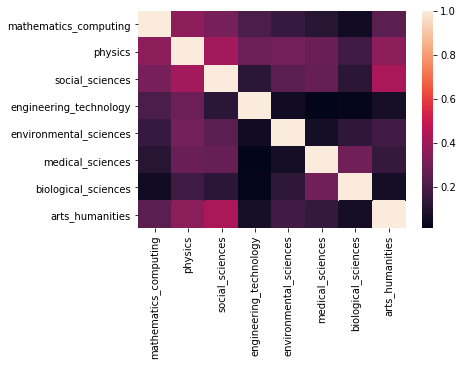

In [38]:
sns.heatmap(gtr_predicted[discs].applymap(lambda x: 1 if x>0.1 else 0).corr())

This one is interesting - lots of co-occurrences between social sciences and physics. Let's check some of them

In [39]:
gtr_predicted.loc[(gtr_predicted['physics']>0.1) & (gtr_predicted['social_sciences']>0.1),['abstractText']]

,abstractText
0,We take aerial photos of construction sites us...
6,To develop practical tools and guides to be ab...
8,Theme: Agriculture and Food Security
19,student to undertake 3 rotations before choosi...
23,NERC has made a significant investment in Eart...
27,The Business-led APPS2B Project aims to identi...
28,Not required
30,A Journey through Space and Time: an examinati...
31,&quot;University of Brighton\nSchool of Sport ...
32,To embed capability for sustainable growth thr...


#### Who funds what disciplines?

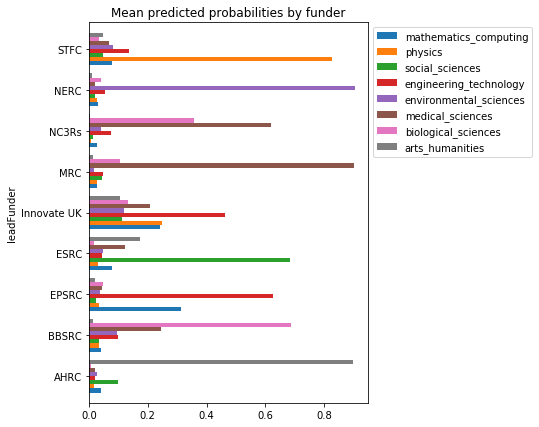

In [40]:
fig,ax = plt.subplots(figsize=(5,7))

gtr_predicted.groupby(['leadFunder'])[discs].mean().plot.barh(ax=ax,width=0.8,title='Mean predicted probabilities by funder')

ax.legend(bbox_to_anchor=(1,1))

Makes sense. Each funder seems to focus on its 'core discipline'

#### What are the trends over times?

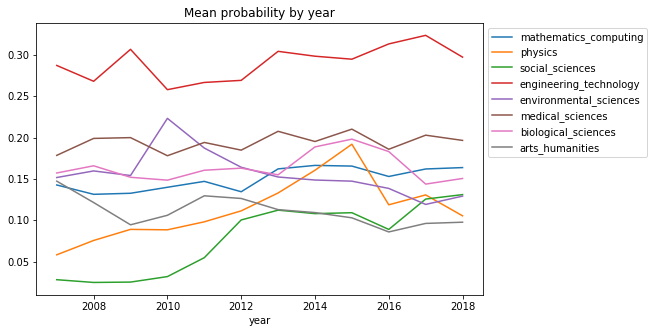

In [41]:
fig,ax = plt.subplots(figsize=(8,5))

gtr_predicted.loc[(gtr_predicted.year>2006) & (gtr_predicted.year<2019)].groupby('year')[discs].mean().plot(ax=ax,title='Mean probability by year')

ax.legend(bbox_to_anchor=(1,1))

#### What about the grant type category?

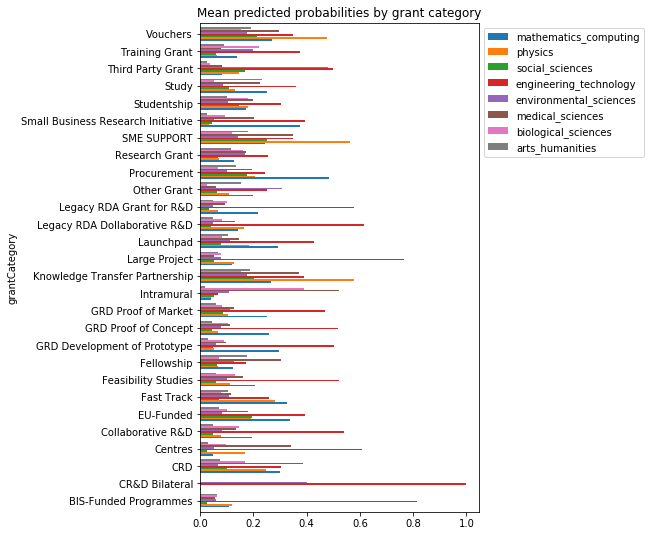

In [42]:
fig,ax = plt.subplots(figsize=(5,9))

gtr_predicted.groupby(['grantCategory'])[discs].mean().plot.barh(ax=ax,width=0.8,title='Mean predicted probabilities by grant category')

ax.legend(bbox_to_anchor=(1,1))

Some important differences here. For example...

* Procurement is dominated by maths. Is this because it picks up IT procuremenr?
* Proof of market / concept projects dominated by engineering and technology.
* Vouchers / SIGs / SME support have a strong presence of physics, picking up access to facilities?

#### And the impact types?

In [43]:
impact_names = ['prods','ip','tech','spin','pubs']

The loop below calculates the % of projects inside a discipline (measured as one with a predicted probability > 0.2) generating an impact of each of the types we are considering. 

In [60]:
results = []

for x in discs:
    
    disc_imp = {}
    
    for impact in impact_names:
        
        out_pc = 100*pd.crosstab(
            gtr_discs[x].apply(lambda x: 1 if x>0.2 else 0),gtr_discs[impact].apply(lambda x: 1 if x>0 else 0),normalize=0).loc[1,1]
        
        disc_imp[impact]=out_pc
        
    disc_out = pd.Series(disc_imp)
    disc_out.name=x
    
    results.append(disc_out)

NameError: name 'gtr_discs' is not defined

In [ ]:
pd.concat(results,axis=1).plot.bar(title='% of projects with impact type by discipline')

Again, this checks out. Medical sciences generate more 'products' (we saw before that this category is mostly used by that RC, maths projects generate more technology...)

### Save for the other notebook

In [ ]:
gtr_predicted[['index']+list(discs)].to_csv(f'../data/processed/{today_str}_gtr_w_predicted_labels.csv')

In [ ]:
discs

In [68]:
la = ['Chronic disease','chronic condition','addiction', 'alzheimers', 'atrial fibrillation', 'autoimmune disease', 'lupus', 'bipolar_disorder', 'blindness',  'cancer', 'cardiovascular disease', 'cerebral palsy', 'chronic hepatitis', 'chronic pain', 'depression', 'deafness', 'blindness', 'endometriosis', 'epilepsy', 'hiv', 'aids', 'Huntingtons', 'hypertension', 'Lymes disease', 'sclerosis', 'Parkinsons','sickle cell anemia']

In [71]:
', '.join(sorted(la))

'Chronic disease, Huntingtons, Lymes disease, Parkinsons, addiction, aids, alzheimers, atrial fibrillation, autoimmune disease, bipolar_disorder, blindness, blindness, cancer, cardiovascular disease, cerebral palsy, chronic condition, chronic hepatitis, chronic pain, deafness, depression, endometriosis, epilepsy, hiv, hypertension, lupus, sclerosis, sickle cell anemia'

In [74]:
', '.join(sorted([x.capitalize() for x in la]))

'Addiction, Aids, Alzheimers, Atrial fibrillation, Autoimmune disease, Bipolar_disorder, Blindness, Blindness, Cancer, Cardiovascular disease, Cerebral palsy, Chronic condition, Chronic disease, Chronic hepatitis, Chronic pain, Deafness, Depression, Endometriosis, Epilepsy, Hiv, Huntingtons, Hypertension, Lupus, Lymes disease, Parkinsons, Sclerosis, Sickle cell anemia'